In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
from scipy.signal import find_peaks
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

def show_image(img, cmap=None, name=None, size=None):
    if size is not None:
        plt.figure(figsize=size)
    else:
        plt.figure(figsize=(3,3))
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')
    if name is not None:
        plt.title(name)
    plt.show()

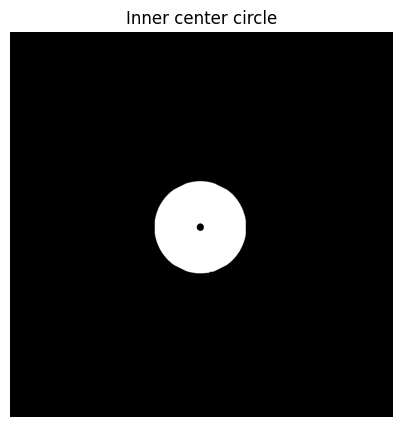

In [56]:
image = io.imread(f'resources/aligned/shot_8.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
res = gray_image.copy()
border_width=50
res[:border_width, :] = 255
res[-border_width:, :] = 255
res[:, :border_width] = 255
res[:, -border_width:] = 255
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel, res, iterations=3)
cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel, res, iterations=25)
threshold = 80
res[res < threshold] = 0
res[res >= threshold] = 255
res = cv2.bitwise_not(res)
show_image(res, cmap="gray", size=(5,5), name="Inner center circle")

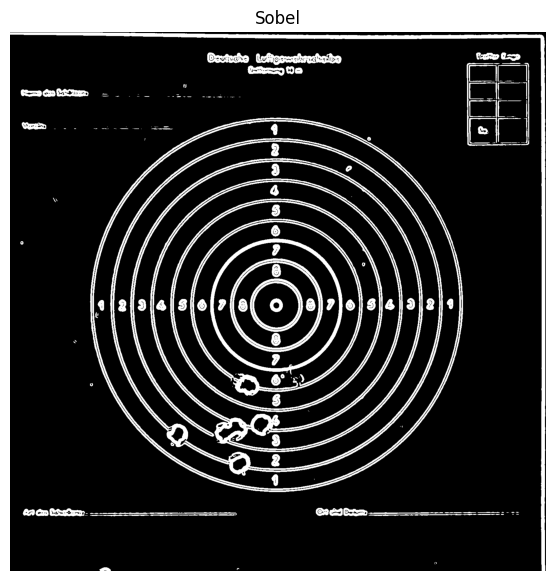

In [57]:
gray_image_blur = cv2.GaussianBlur(gray_image, (15,15), 0)
sobelx = cv2.Sobel(gray_image_blur, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image_blur, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# CV2 sobel ist deutlich schneller als selber geschriebener
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
threshold = 40
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255

show_image(sobel, cmap="gray", size=(7,7), name="Sobel")

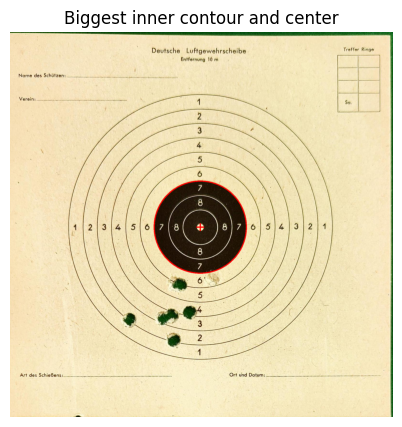

In [58]:
contours, _ = cv2.findContours(res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_cntr = None
biggest_radius = 0
marked = image.copy()
for contour in contours:
    radius = cv2.minEnclosingCircle(contour)[1]
    if radius > biggest_radius:
        biggest_radius = radius
        biggest_cntr = contour
# Zentrum der größten Kontur über minimal umschließenden Kreis
(centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)
centerX = int(centerX)
centerY = int(centerY)
cv2.drawMarker(marked, (centerX, centerY), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
cv2.circle(marked, (centerX, centerY), int(biggest_radius), (255, 0, 0), 3)
show_image(marked, size=(5,5), name='Biggest inner contour and center')

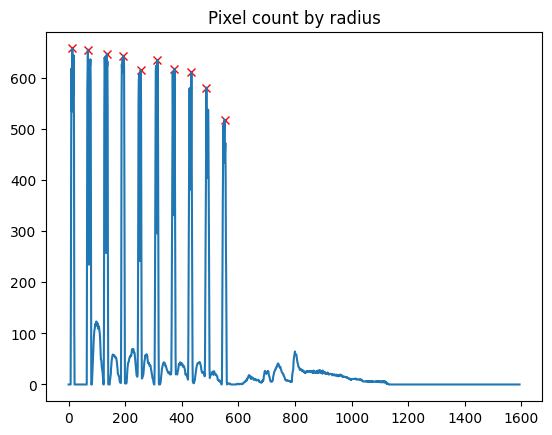

In [59]:
def hough_circles_around_center(image, fix,img):
    dict = {}
    height, width = image.shape
    acc_length_factor = 1
    length_acc = width * acc_length_factor
    acc = np.zeros(length_acc)
    x_f, y_f = fix
    for x in range(0, width):
        for y in range(0, height):

            if image[y, x] > 0:
                radius = np.floor(
                    np.sqrt((x_f - x)**2 + (y_f - y)**2) * acc_length_factor).astype("int")
                if not radius in dict:
                    dict[radius]=[]
                acc[radius] = acc[radius] + 1
                dict[radius].append((x,y))

    # Kleiner Radius = weniger Punkte auf dem Kreis
    acc = acc / ((np.arange(len(acc))+1)/acc_length_factor)
    acc = acc * 100
    max = np.max(acc)
    peaks, _ = find_peaks(acc, prominence=1, distance=40, height=0.5*max)

    plt.plot(peaks,  acc[peaks], "xr")
    plt.plot(acc)
    plt.title("Pixel count by radius")
    plt.show()

    summed={}
    for peak in peaks:
        if not peak in summed:
            summed[peak]=[]
        for r in range(-15,15):
            if (peak+r) in dict:
                summed[peak].extend(dict[peak+r])


    indices = np.nonzero(acc)
    indices = np.array(indices).astype("int").flatten()
    return (peaks/acc_length_factor).astype("int"),summed

circles,summed = hough_circles_around_center(sobel, (centerX, centerY),image)


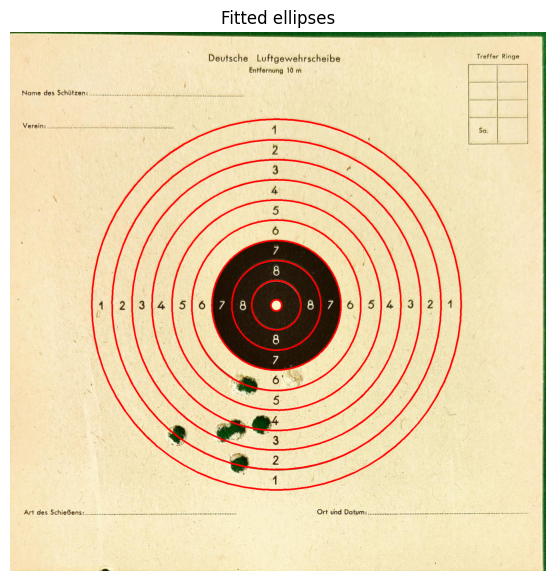

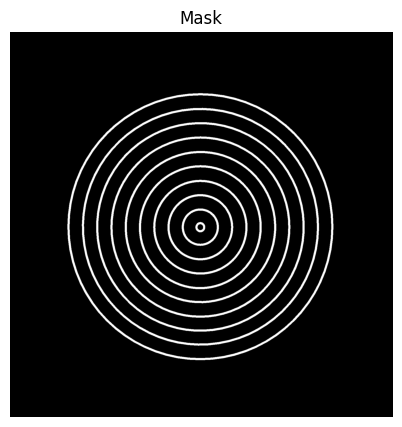

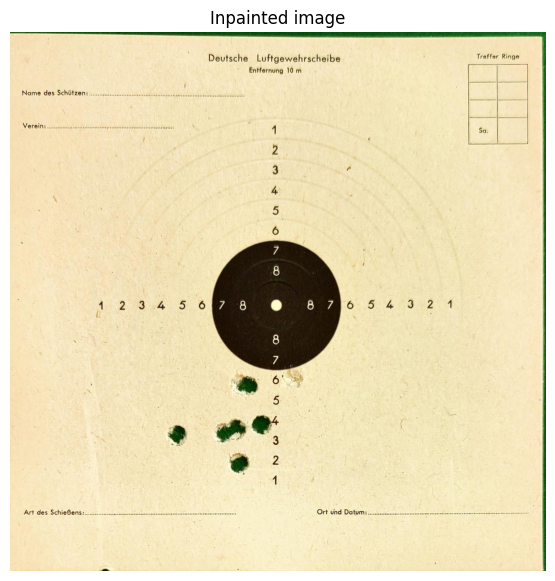

In [60]:
mask = np.zeros_like(gray_image)
marked = image.copy()
ellipses = []
for elem in summed.values():
    ellipse = cv2.fitEllipse(np.array(elem))
    ellipses.append(ellipse)    
    cv2.ellipse(mask, ellipse, 255, 8)
    cv2.ellipse(marked, ellipse, (255, 0, 0), 4)
show_image(marked,size=(7,7), name="Fitted ellipses")
show_image(mask, cmap="gray", size=(5,5), name="Mask")
inpainted = cv2.inpaint(image, mask, 4, cv2.INPAINT_TELEA)
show_image(inpainted, size=(7,7), name="Inpainted image")

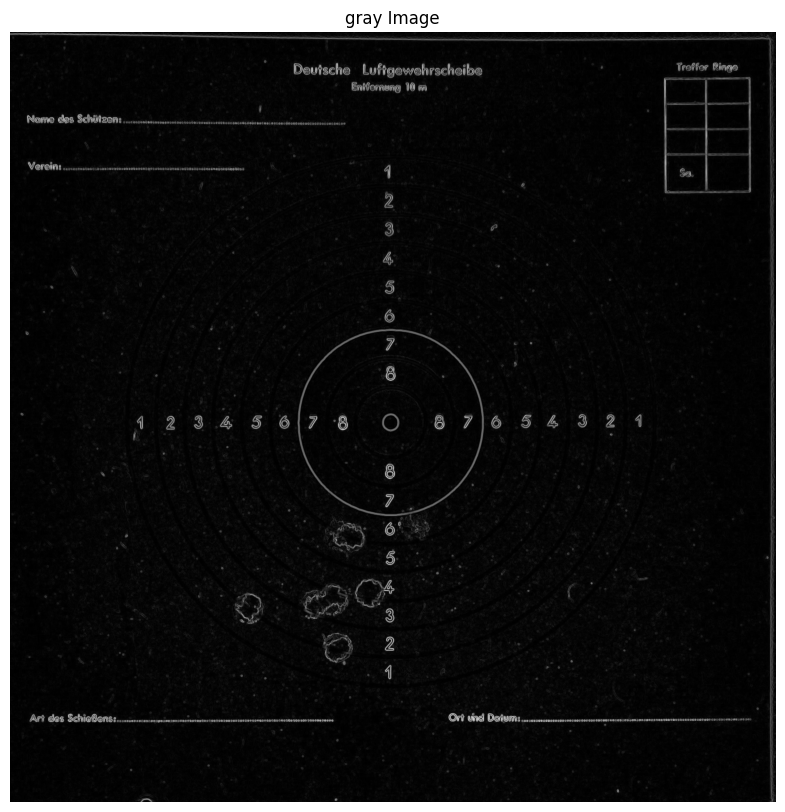

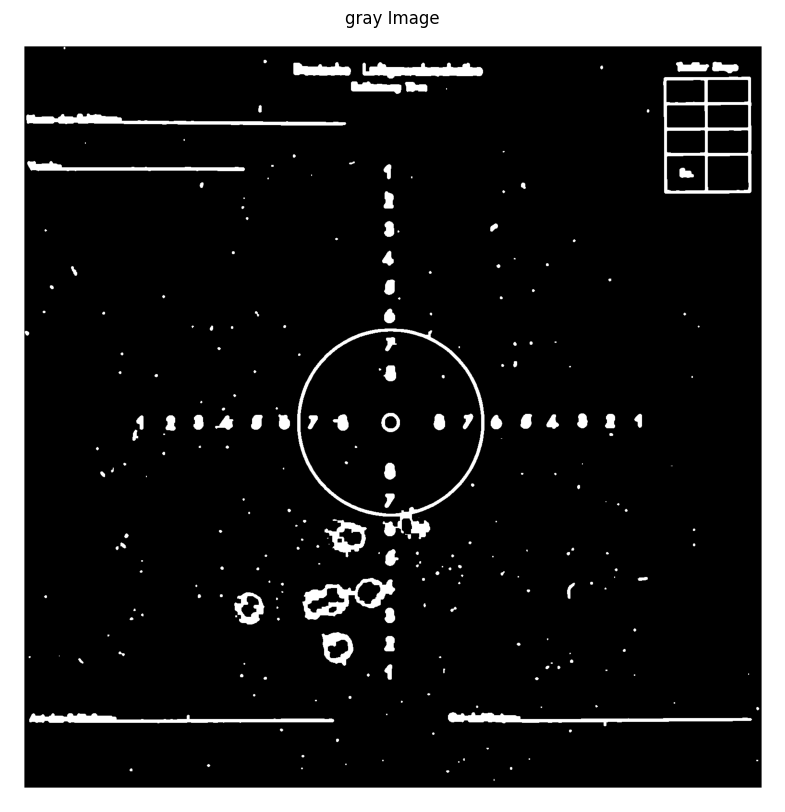

In [67]:

gray_image = cv2.cvtColor(inpainted, cv2.COLOR_RGB2GRAY)

#gray_image_blur = cv2.GaussianBlur(gray_image, (15,15), 0)
sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)
show_image(sobel, name='gray Image',cmap="gray", size=(10, 10))
# CV2 sobel ist deutlich schneller als selber geschriebener
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
threshold = 40
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255
# CV2 sobel ist deutlich schneller als selber geschriebener
cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
kernel = np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1]], dtype=np.uint8)
#cv2.morphologyEx(sobel, cv2.MORPH_OPEN, kernel, sobel, iterations=1)

sobel = cv2.GaussianBlur(sobel, (5, 5), 3)
#cv2.morphologyEx(sobel, cv2.MORPH_CLOSE, kernel, sobel, iterations=2)
#cv2.morphologyEx(sobel, cv2.MORPH_OPEN, kernel, sobel, iterations=1)
kernel = np.ones((3, 3), np.uint8)
sobel = cv2.dilate(sobel, kernel, iterations=3)
sobel = cv2.erode(sobel, kernel, iterations=3)
#cv2.dilate()
threshold = 50
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255
#sobel = np.invert(sobel)
border_width=30
sobel[:border_width, :] = 255
sobel[-border_width:, :] = 255
sobel[:, :border_width] = 255
sobel[:, -border_width:] = 255
show_image(sobel, name='gray Image',cmap="gray", size=(10, 10))

In [68]:
@widgets.interact(
filterByArea = widgets.ToggleButton(
    value=True,
    description='Grid',
    icon='check'
),
filterByCircularity = widgets.ToggleButton(
    value=False,
    description='Grid',
    icon='check'
),
filterByConvexity = widgets.ToggleButton(
    value=False,
    description='Grid',
    icon='check'
),
filterByInertia = widgets.ToggleButton(
    value=True,
    description='Grid',
    icon='check'
),threshold = widgets.FloatRangeSlider(
    value=[0., +255.],
    min=0.01, max=+255., step=1,
    description='threshold:',
    readout_format='.1f',
),area = widgets.FloatRangeSlider(
    value=[300, 1200],
    min=0.01, max=+10000., step=100,
    description='area:',
    readout_format='.1f',
),Circularity = widgets.FloatRangeSlider(
    value=[0.01, +1.],
    min=0.01, max=+1., step=0.01,
    description='Circularity:',
    readout_format='.2f',
),Convexity = widgets.FloatRangeSlider(
    value=[0.19, +1.],
    min=0.01, max=+1., step=0.01,
    description='Convexity:',
    readout_format='.2f',
),Inertia = widgets.FloatRangeSlider(
    value=[0.15, +1.],
    min=0.01, max=+1., step=0.01,
    description='Inertia:',
    readout_format='.2f',
))
def f(filterbyArea=True,filterbyCircularity=True,filterbyConvexity=True,filterbyInertia=True,threshold=(0., 255.),area=(100., 1000.),Circularity=(0.01, 1.),Convexity=(0.01, 1.),Inertia=(0.01, 1.)):
    # Set up the SimpleBlobDetector with default parameters
    params = cv2.SimpleBlobDetector_Params()

    # Set the threshold
    params.minThreshold = threshold[0]
    params.maxThreshold = threshold[1]

    # Set the area filter
    params.filterByArea = filterbyArea
    params.minArea = area[0]
    params.maxArea = area[1]

    # Set the circularity filter
    params.filterByCircularity = filterbyCircularity
    params.minCircularity = Circularity[0]
    params.maxCircularity = Circularity[1]

    # Set the convexity filter
    params.filterByConvexity = filterbyConvexity
    params.minConvexity = Convexity[0]
    params.maxConvexity = Convexity[1]
    # Set the inertia filter
    params.filterByInertia = filterbyInertia
    params.minInertiaRatio = Inertia[0]
    params.maxInertiaRatio = Inertia[1]

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(sobel)

    # Draw detected blobs as red circles
    img_with_keypoints = image.copy()
    counter =1
    for keypoint in keypoints:
        x = int(keypoint.pt[0])
        y = int(keypoint.pt[1])
        cv2.putText(img_with_keypoints, str(counter), (x-50, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        cv2.circle(img_with_keypoints, (x, y), 25, (255, 0, 0), 3)
        counter+=1

    # Show the image with detected blobs

    show_image(img_with_keypoints, name='Keypoints', size=(10, 10))



interactive(children=(Checkbox(value=True, description='filterbyArea'), Checkbox(value=True, description='filt…